ESTADISTICAS GENERALES DEL CHAT

Total de mensajes: 979
Usuarios unicos: 18
Promedio de mensajes por usuario: 54.39

Distribucion por tipo de mensaje:
tipo_mensaje
texto       943
sistema      25
encuesta     11
Name: count, dtype: int64

Usuarios en el grupo:
['Luffy' 'Zoro' 'Nami' 'Usopp' 'Sanji' 'Chopper' 'Robin' 'Franky' 'Brook'
 'Jinbe' 'Ace' 'Sabo' 'Law' 'Kid' 'Shanks' 'Mihawk' 'Boa' 'Crocodile']


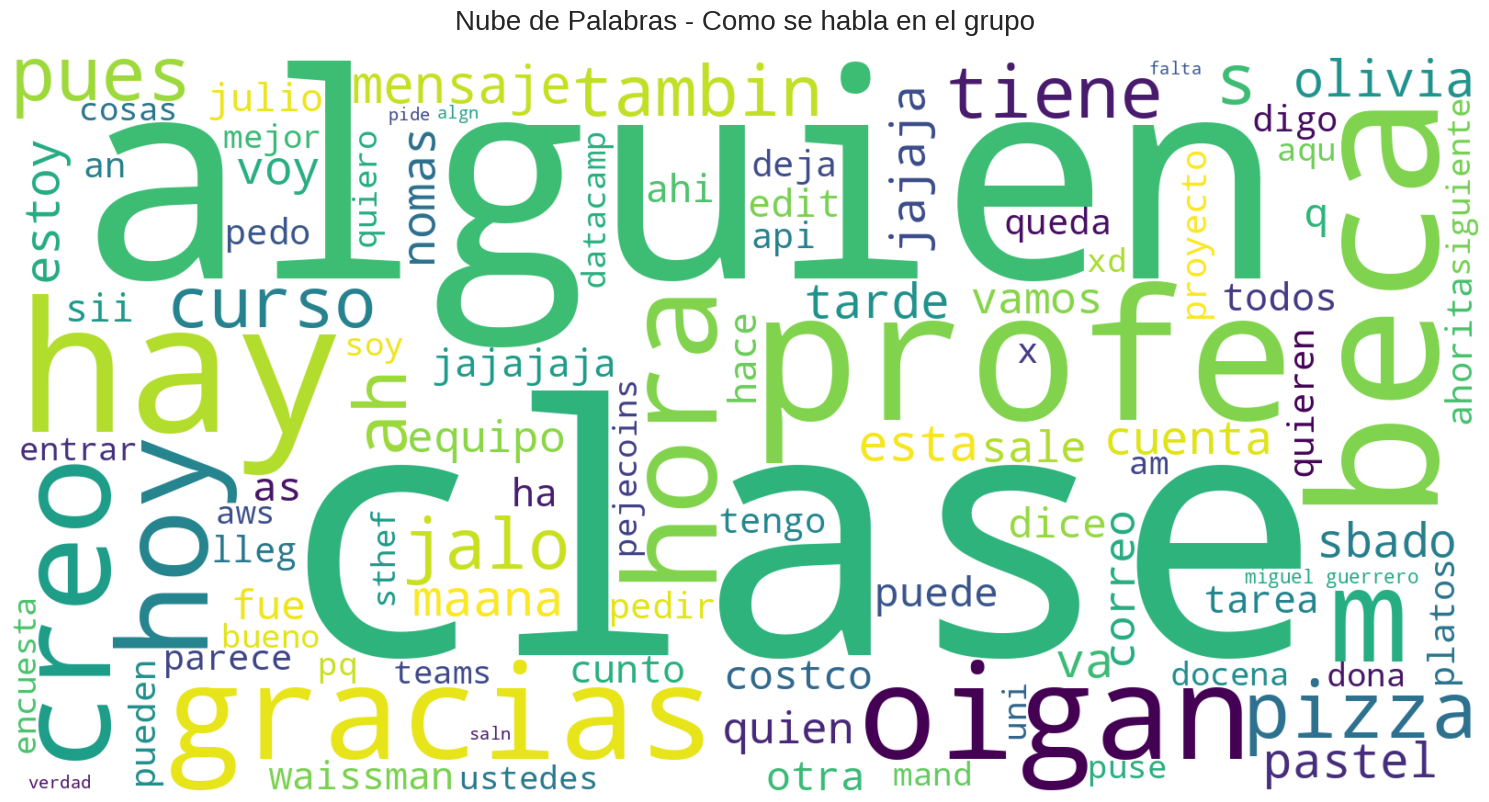

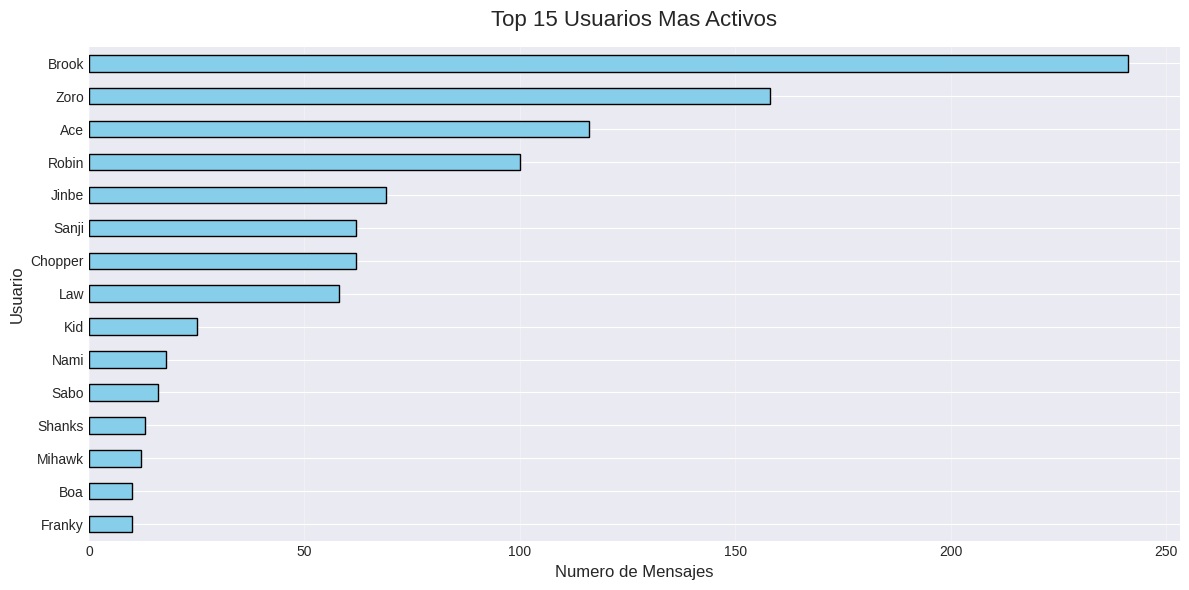

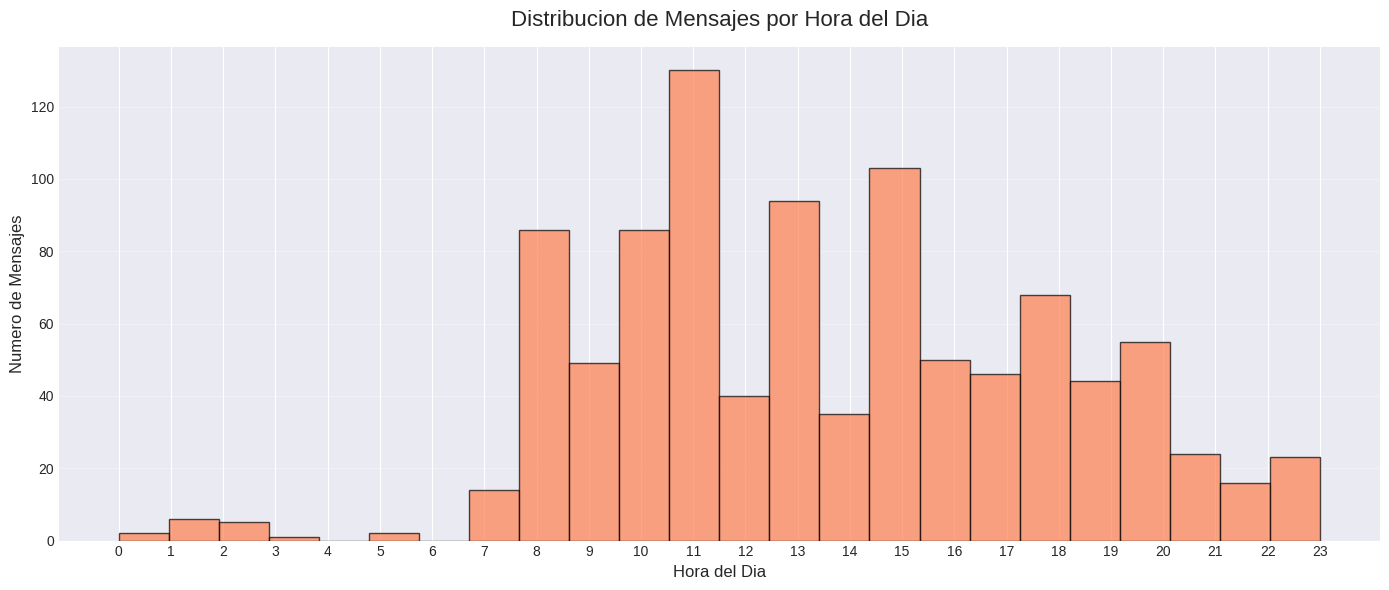

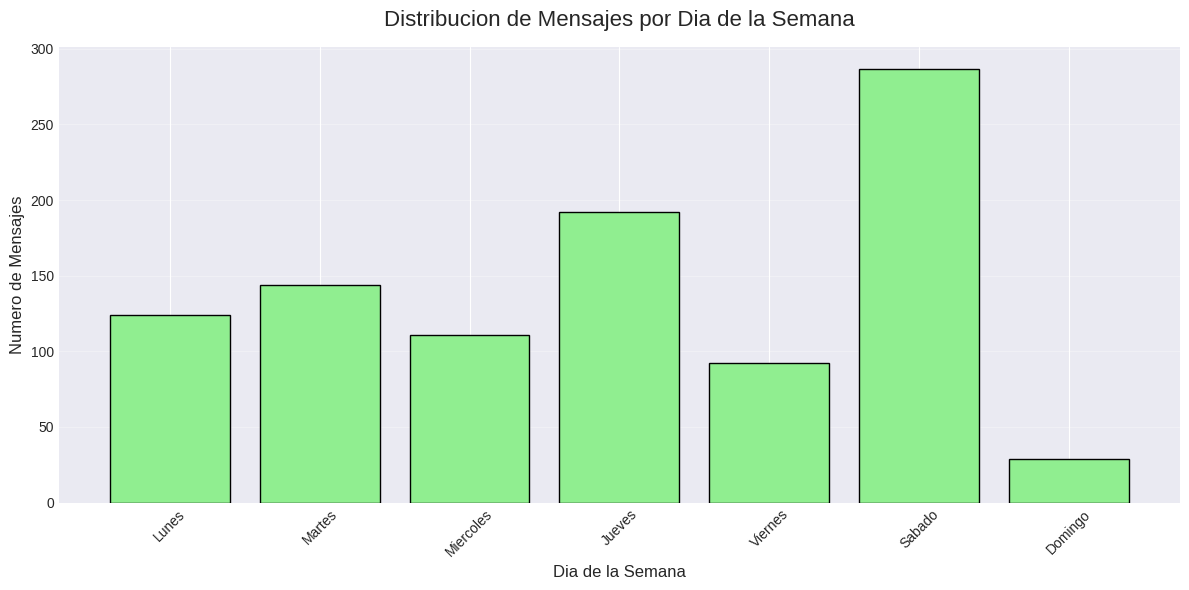

<Figure size 1400x700 with 0 Axes>

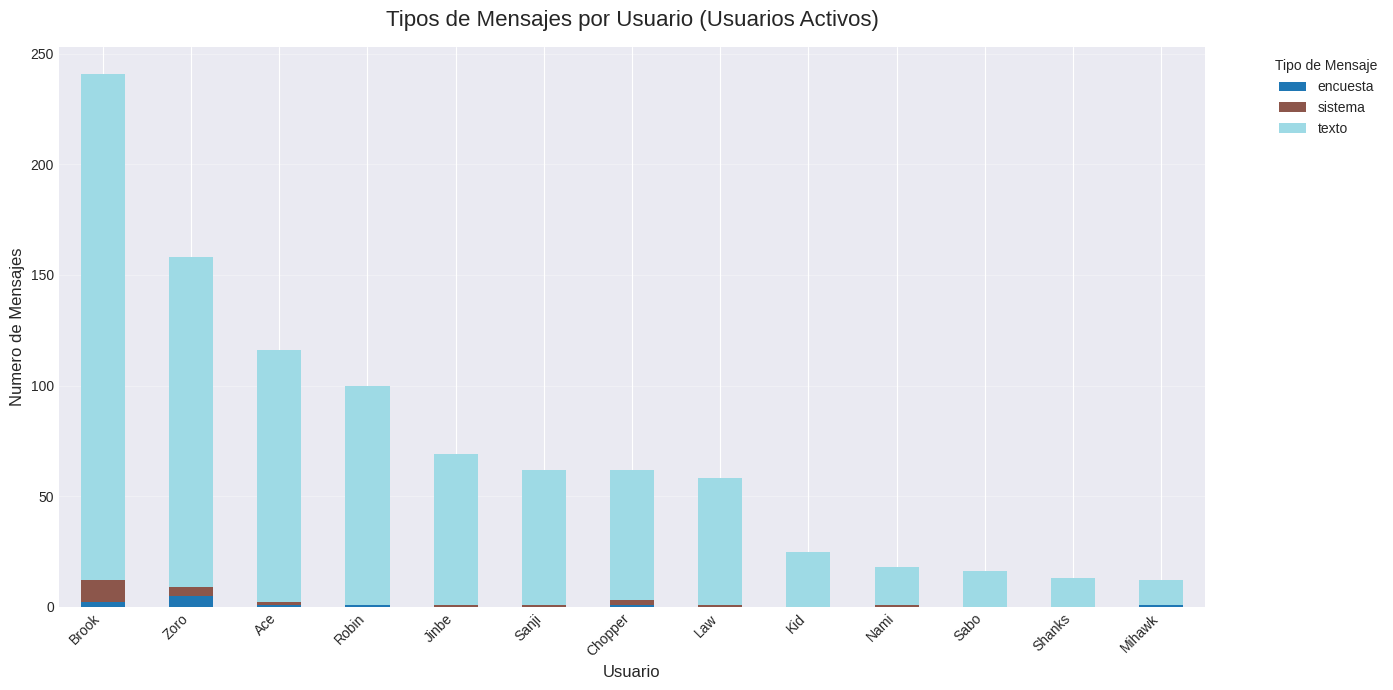

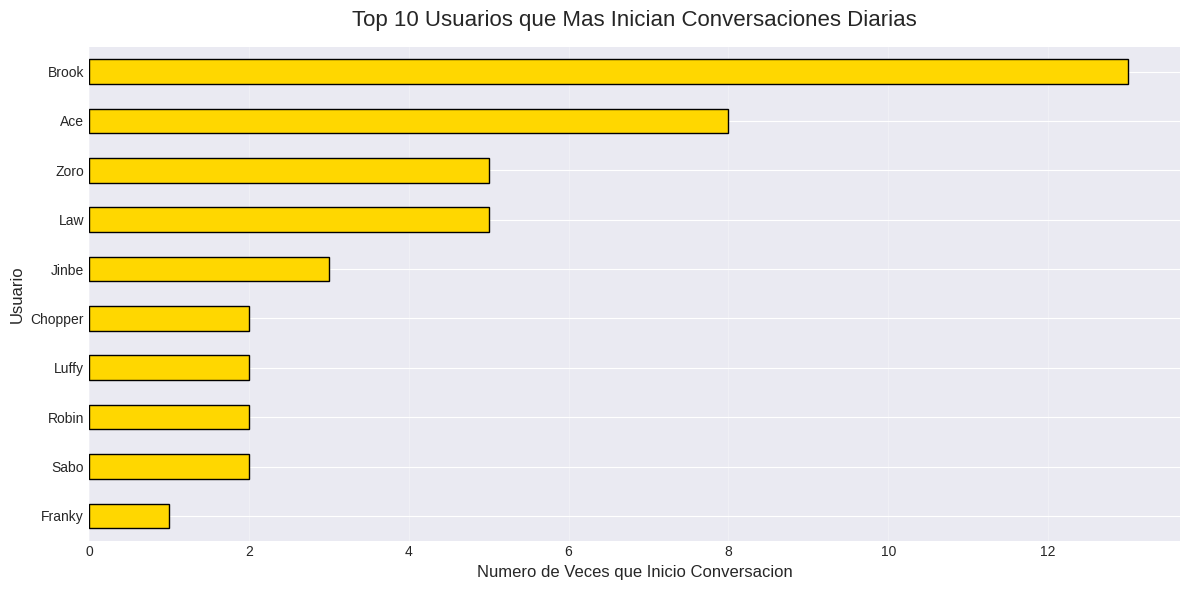


Usuarios que mas inician conversaciones:
usuario
Brook      13
Ace         8
Zoro        5
Law         5
Jinbe       3
Chopper     2
Luffy       2
Robin       2
Sabo        2
Franky      1
Name: count, dtype: int64


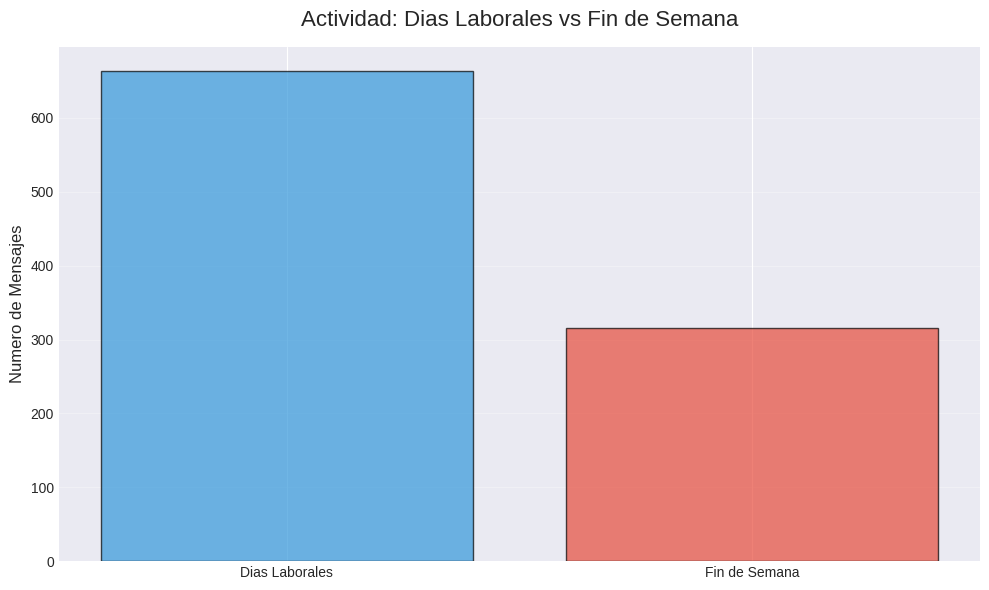


Comparacion de actividad:
Dias laborales: 663 mensajes
Fin de semana: 316 mensajes


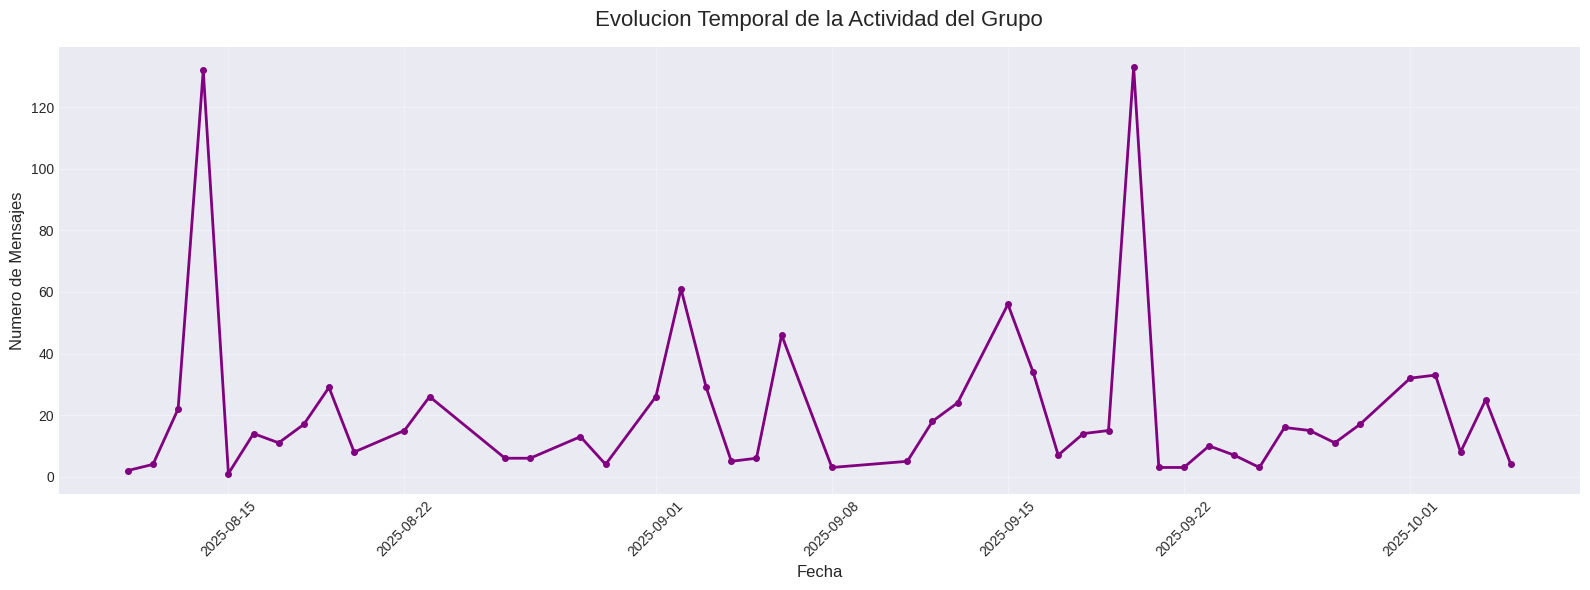

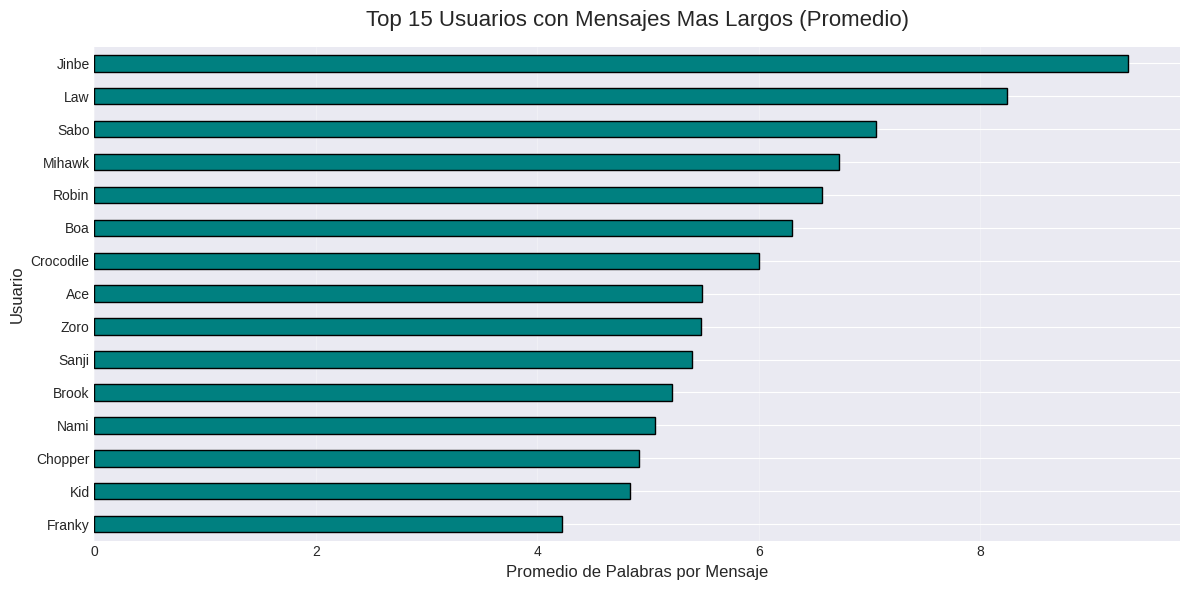


Longitud promedio de mensajes (Top 10):
usuario
Jinbe        9.338235
Law          8.245614
Sabo         7.062500
Mihawk       6.727273
Robin        6.575758
Boa          6.300000
Crocodile    6.000000
Ace          5.491228
Zoro         5.483221
Sanji        5.393443
Name: num_palabras, dtype: float64

RESUMEN FINAL DEL ANALISIS

Total de mensajes analizados: 979
Periodo analizado: 2025-08-11 a 2025-10-05
Usuario mas activo: Brook (241 mensajes)
Hora mas activa: 11:00 hrs
Dia mas activo: Sabado
Usuario que mas inicia conversaciones: Brook
Tipo de mensaje mas comun: texto

Analisis completado exitosamente!


In [13]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

usuario_map = {}
personajes_one_piece = [
    'Luffy', 'Zoro', 'Nami', 'Usopp', 'Sanji',
    'Chopper', 'Robin', 'Franky', 'Brook', 'Jinbe',
    'Ace', 'Sabo', 'Law', 'Kid', 'Shanks',
    'Mihawk', 'Boa', 'Crocodile', 'Doflamingo', 'Katakuri'
]
personaje_idx = 0

def anonimizar_usuario(usuario):
    """Mapea usuarios reales a personajes de One Piece"""
    global personaje_idx, usuario_map

    if usuario not in usuario_map:
        if personaje_idx < len(personajes_one_piece):
            usuario_map[usuario] = personajes_one_piece[personaje_idx]
            personaje_idx += 1
        else:
            usuario_map[usuario] = f'Pirata_{personaje_idx}'
            personaje_idx += 1

    return usuario_map[usuario]

def detectar_tipo_mensaje(mensaje):
    """Detecta el tipo de mensaje usando expresiones regulares"""

    patrones = {
        'imagen': r'(?i)(imagen omitida|image omitted)',
        'video': r'(?i)(video omitido|video omitted)',
        'sticker': r'(?i)(sticker omitido|sticker omitted)',
        'audio': r'(?i)(audio omitido|audio omitted)',
        'documento': r'(?i)(documento omitido|document omitted)',
        'gif': r'(?i)(gif omitido|gif omitted)',
        'encuesta': r'(?i)(encuesta:|opcion:)',
        'sistema': r'(?i)(se unio|uniste|creo este grupo|grupo|cifrado|encrypted|joined|created|anadio|añadio|fijo un mensaje|eliminó este mensaje)',
        'contacto': r'(?i)(contacto compartido|contact shared)',
        'ubicacion': r'(?i)(ubicacion:|location:)'
    }

    for tipo, patron in patrones.items():
        if re.search(patron, mensaje):
            return tipo

    return 'texto'

def contar_palabras(mensaje, tipo):
    """Cuenta palabras solo en mensajes de texto usando expresiones regulares"""
    if tipo == 'texto':
        palabras = re.findall(r'\b\w+\b', mensaje)
        return len(palabras)
    return 0

def parsear_chat_whatsapp(ruta_archivo):
    """
    Lee y procesa el archivo de chat de WhatsApp
    Extrae: fecha, hora, usuario, mensaje, tipo y numero de palabras
    """
    patron_linea = r'\[(\d{1,2}/\d{1,2}/\d{2,4}),\s+(\d{1,2}:\d{2}:\d{2})\s*([ap]\.?\s*m\.?)\]\s*([^:]+?):\s*(.*)'

    datos = []

    with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
        lineas = archivo.readlines()

        for i, linea in enumerate(lineas):
            match = re.match(patron_linea, linea, re.IGNORECASE)

            if match:
                fecha = match.group(1)
                hora = match.group(2)
                ampm = match.group(3).strip()
                usuario_raw = match.group(4).strip()
                mensaje = match.group(5).strip()

                usuario_raw = re.sub(r'[~\s]+', ' ', usuario_raw).strip()
                usuario_raw = re.sub(r'\s+', ' ', usuario_raw)

                usuario = anonimizar_usuario(usuario_raw)

                tipo = detectar_tipo_mensaje(mensaje)

                num_palabras = contar_palabras(mensaje, tipo)

                fecha_hora_str = f'{fecha} {hora} {ampm}'

                datos.append({
                    'fecha_hora_str': fecha_hora_str,
                    'usuario': usuario,
                    'mensaje': mensaje,
                    'tipo_mensaje': tipo,
                    'num_palabras': num_palabras
                })

    return pd.DataFrame(datos)


ruta_archivo = 'chat_whatsapp.txt'

df = parsear_chat_whatsapp(ruta_archivo)

def parse_datetime_flexible(fecha_hora_str):
    """Intenta parsear fechas con diferentes formatos"""
    formatos = [
        '%d/%m/%y %I:%M:%S %p',
        '%d/%m/%y %I:%M:%S %PM',
        '%d/%m/%Y %I:%M:%S %p',
        '%d/%m/%Y %I:%M:%S %PM'
    ]

    for formato in formatos:
        try:
            fecha_limpia = re.sub(r'\s+', ' ', fecha_hora_str)
            fecha_limpia = re.sub(r'([ap])\.?\s*m\.?', r'\1m', fecha_limpia, flags=re.IGNORECASE)
            return pd.to_datetime(fecha_limpia, format=formato)
        except:
            continue
    return pd.NaT

df['fecha_hora'] = df['fecha_hora_str'].apply(parse_datetime_flexible)

df['fecha'] = df['fecha_hora'].dt.date
df['hora'] = df['fecha_hora'].dt.hour
df['dia_semana'] = df['fecha_hora'].dt.day_name()
df['es_fin_semana'] = df['fecha_hora'].dt.dayofweek.isin([5, 6])

if df['fecha_hora'].isna().sum() > 0:
    print("\nEjemplos de strings de fecha que no se parsearon:")
    print(df[df['fecha_hora'].isna()]['fecha_hora_str'].head())

print("="*60)
print("ESTADISTICAS GENERALES DEL CHAT")
print("="*60)

total_mensajes = len(df)
usuarios_unicos = df['usuario'].nunique()
promedio_mensajes = total_mensajes / usuarios_unicos if usuarios_unicos > 0 else 0

print(f"\nTotal de mensajes: {total_mensajes}")
print(f"Usuarios unicos: {usuarios_unicos}")
print(f"Promedio de mensajes por usuario: {promedio_mensajes:.2f}")

print("\nDistribucion por tipo de mensaje:")
print(df['tipo_mensaje'].value_counts())

print("\nUsuarios en el grupo:")
print(df['usuario'].unique())

mensajes_texto = df[df['tipo_mensaje'] == 'texto']['mensaje']

texto_completo = ' '.join(mensajes_texto.astype(str))

texto_limpio = re.sub(r'[^a-zA-Z\s]', '', texto_completo.lower())

stopwords_es = set([
    'el', 'la', 'de', 'que', 'y', 'a', 'en', 'un', 'ser', 'se', 'no', 'haber',
    'por', 'con', 'su', 'para', 'como', 'estar', 'tener', 'le', 'lo', 'todo',
    'pero', 'mas', 'hacer', 'o', 'poder', 'decir', 'este', 'ir', 'otro', 'ese',
    'si', 'me', 'ya', 'ver', 'porque', 'dar', 'cuando', 'muy',
    'sin', 'vez', 'mucho', 'saber', 'sobre', 'mi', 'alguno', 'mismo',
    'yo', 'tambien', 'hasta', 'ano', 'dos', 'querer', 'entre', 'asi', 'primero',
    'desde', 'grande', 'eso', 'ni', 'nos', 'llegar', 'pasar', 'tiempo', 'ella',
    'dia', 'uno', 'bien', 'poco', 'deber', 'entonces', 'poner', 'cosa',
    'tanto', 'hombre', 'parecer', 'nuestro', 'tan', 'donde', 'ahora', 'parte',
    'despues', 'vida', 'quedar', 'siempre', 'creer', 'hablar', 'llevar', 'dejar',
    'nada', 'cada', 'seguir', 'menos', 'nuevo', 'encontrar', 'algo', 'solo',
    'salir', 'volver', 'tomar', 'conocer', 'sentir', 'cual', 'mirar',
    'ante', 'ellos', 'e', 'esto', 'antes', 'algunos', 'unos', 'del', 'al', 'es',
    'te', 'tu', 'las', 'los', 'sus', 'una', 'les', 'dijo', 'qu', 'dej', 'est',
    'estn', 'da'
])

plt.figure(figsize=(15, 8))
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    stopwords=stopwords_es,
    colormap='viridis',
    max_words=100
).generate(texto_limpio)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Como se habla en el grupo', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

mensajes_por_usuario = df['usuario'].value_counts().head(15)

if len(mensajes_por_usuario) > 0:
    plt.figure(figsize=(12, 6))
    mensajes_por_usuario.plot(kind='barh', color='skyblue', edgecolor='black')
    plt.xlabel('Numero de Mensajes', fontsize=12)
    plt.ylabel('Usuario', fontsize=12)
    plt.title('Top 15 Usuarios Mas Activos', fontsize=16, pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(14, 6))
df['hora'].hist(bins=24, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Hora del Dia', fontsize=12)
plt.ylabel('Numero de Mensajes', fontsize=12)
plt.title('Distribucion de Mensajes por Hora del Dia', fontsize=16, pad=15)
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_es = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']

mensajes_por_dia = df['dia_semana'].value_counts().reindex(orden_dias)

plt.figure(figsize=(12, 6))
plt.bar(dias_es, mensajes_por_dia.values, color='lightgreen', edgecolor='black')
plt.xlabel('Dia de la Semana', fontsize=12)
plt.ylabel('Numero de Mensajes', fontsize=12)
plt.title('Distribucion de Mensajes por Dia de la Semana', fontsize=16, pad=15)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

tipo_por_usuario = df.groupby(['usuario', 'tipo_mensaje']).size().unstack(fill_value=0)

usuarios_activos = df['usuario'].value_counts()[df['usuario'].value_counts() > 10].index
tipo_por_usuario_filtrado = tipo_por_usuario.loc[usuarios_activos]

plt.figure(figsize=(14, 7))
tipo_por_usuario_filtrado.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20')
plt.xlabel('Usuario', fontsize=12)
plt.ylabel('Numero de Mensajes', fontsize=12)
plt.title('Tipos de Mensajes por Usuario (Usuarios Activos)', fontsize=16, pad=15)
plt.legend(title='Tipo de Mensaje', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

df_sorted = df.sort_values('fecha_hora')
primeros_mensajes = df_sorted.groupby('fecha').first()['usuario']

iniciadores = primeros_mensajes.value_counts()

if len(iniciadores) > 0:
    plt.figure(figsize=(12, 6))
    iniciadores.head(10).plot(kind='barh', color='gold', edgecolor='black')
    plt.xlabel('Numero de Veces que Inicio Conversacion', fontsize=12)
    plt.ylabel('Usuario', fontsize=12)
    plt.title('Top 10 Usuarios que Mas Inician Conversaciones Diarias', fontsize=16, pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nUsuarios que mas inician conversaciones:")
    print(iniciadores.head(10))
else:
    print("No hay datos suficientes para analizar iniciadores de conversaciones")


actividad_semana = df.groupby('es_fin_semana').size()

labels = ['Dias Laborales', 'Fin de Semana']
colores = ['#3498db', '#e74c3c']

plt.figure(figsize=(10, 6))
valores_semana = [actividad_semana.get(False, 0), actividad_semana.get(True, 0)]
plt.bar(labels, valores_semana, color=colores, edgecolor='black', alpha=0.7)
plt.ylabel('Numero de Mensajes', fontsize=12)
plt.title('Actividad: Dias Laborales vs Fin de Semana', fontsize=16, pad=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nComparacion de actividad:")
print(f"Dias laborales: {actividad_semana.get(False, 0)} mensajes")
print(f"Fin de semana: {actividad_semana.get(True, 0)} mensajes")

mensajes_por_fecha = df.groupby('fecha').size()

plt.figure(figsize=(16, 6))
plt.plot(mensajes_por_fecha.index, mensajes_por_fecha.values,
         marker='o', linewidth=2, markersize=4, color='purple')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Numero de Mensajes', fontsize=12)
plt.title('Evolucion Temporal de la Actividad del Grupo', fontsize=16, pad=15)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_texto = df[df['tipo_mensaje'] == 'texto'].copy()

if len(df_texto) > 0:
    longitud_promedio = df_texto.groupby('usuario')['num_palabras'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    longitud_promedio.head(15).plot(kind='barh', color='teal', edgecolor='black')
    plt.xlabel('Promedio de Palabras por Mensaje', fontsize=12)
    plt.ylabel('Usuario', fontsize=12)
    plt.title('Top 15 Usuarios con Mensajes Mas Largos (Promedio)', fontsize=16, pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nLongitud promedio de mensajes (Top 10):")
    print(longitud_promedio.head(10))

print("\n" + "="*60)
print("RESUMEN FINAL DEL ANALISIS")
print("="*60)

print(f"\nTotal de mensajes analizados: {total_mensajes}")
print(f"Periodo analizado: {df['fecha'].min()} a {df['fecha'].max()}")

if len(mensajes_por_usuario) > 0:
    print(f"Usuario mas activo: {mensajes_por_usuario.index[0]} ({mensajes_por_usuario.values[0]} mensajes)")

if len(df['hora']) > 0:
    print(f"Hora mas activa: {df['hora'].mode()[0] if len(df['hora'].mode()) > 0 else 'N/A'}:00 hrs")

if len(mensajes_por_dia) > 0:
    dia_max_idx = mensajes_por_dia.idxmax()
    if dia_max_idx in orden_dias:
        print(f"Dia mas activo: {dias_es[orden_dias.index(dia_max_idx)]}")

if len(iniciadores) > 0:
    print(f"Usuario que mas inicia conversaciones: {iniciadores.index[0]}")

print(f"Tipo de mensaje mas comun: {df['tipo_mensaje'].mode()[0] if len(df['tipo_mensaje'].mode()) > 0 else 'N/A'}")

print("\n" + "="*60)
print("Analisis completado exitosamente!")
print("="*60)